In [8]:
%%time

from utils.utils import create_dataset, Trainer

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))

Training on [cpu].
Wall time: 8.36 s


In [52]:
%%time

SAMPLE_NUM = 10000
task = 'regression'  # 'classification'
dataset = create_dataset('movielens', sample_num=SAMPLE_NUM, task=task, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()

Wall time: 38.8 ms


In [73]:
class EE_Loss:
    def __init__(self, model, reg_biase=0.005, reg_lambda=0.005):
        self.reg_biase = reg_biase
        self.reg_lambda = reg_lambda
        self.model = model

    def __call__(self, pred, target):
        loss = (1-self.reg_biase - self.reg_lambda) * nn.MSELoss()(pred, target)
        loss += self.reg_biase * self.model.loss[0]
        loss += self.reg_lambda * self.model.loss[1]
        return loss


class EuclideanEmbedding(nn.Module):

    def __init__(self, field_dims, embed_dim=4):
        super(EuclideanEmbedding, self).__init__()
        n_users, n_movies = field_dims[0], field_dims[1]
        self.Bu = nn.Parameter(torch.randn(n_users), requires_grad=True)
        self.Bm = nn.Parameter(torch.randn(n_movies), requires_grad=True)
        self.u = nn.Embedding(n_users, embed_dim)
        self.m = nn.Embedding(n_movies, embed_dim)
        
        self.u.weight.data.uniform_(0, 0.05)
        self.m.weight.data.uniform_(0, 0.05)
        self.loss = (0,0)

        
    def forward(self, x, global_mean=0):
        users, movies = x[:,0], x[:,1]
        u, m = self.u(users), self.m(movies)
        Bu, Bm = self.Bu[users], self.Bm[movies]
        difference = u-m
        output = global_mean + Bu + Bm - torch.linalg.norm(torch.mul(difference, difference))
        
        self.loss[0] = torch.norm(Bu) + torch.norm(Bm)
        self.loss[1] = torch.norm(u), torch.norm(m)
        return output

In [74]:
ee = EuclideanEmbedding([10, 37])

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [27:05<00:00,  3.25s/it]


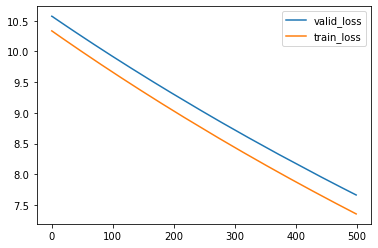

train_loss: 7.35021 | train_metric: -7.35021
valid_loss: 7.66142 | valid_metric: -7.66142
test_loss:  7.92030 | test_metric:  -7.92030
Wall time: 27min 7s


In [76]:
%%time

EMBEDDING_DIM = 8
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 1024
EPOCH = 500
TRIAL = 100

ee = EuclideanEmbedding(field_dims, EMBEDDING_DIM).to(device)

optimizer = optim.Adam(cf.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
# criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()
criterion = EE_Loss(model=ee)

trainer = Trainer(cf, optimizer, criterion, BATCH_SIZE, task=task)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_metric = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_metric:  {:.5f}'.format(test_loss, test_metric))
